In [49]:
# imports
import pandas as pd
import os
from collections import Counter, defaultdict
import numpy as np

import math
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

tokenizer = RegexpTokenizer(r'\w+')

stop_words = set(stopwords.words('english'))
wnl = nltk.WordNetLemmatizer() # The WordNet lemmatizer removes affixes if the resulting word is in its dictionary.

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:
# load tracks dataset
tracks_df = pd.read_pickle(r'/content/drive/MyDrive/SocialGraphs/Spotify_data/tracks_dataset_lyrics.pickle')
# load spotify dataset
spotify_df = pd.read_pickle(r"/content/drive/MyDrive/SocialGraphs/Spotify_data/spotify_dataset_processed.pickle")

# Wordclouds for top 5 genres

In [103]:
# compute the genres frequency
genre_counter = Counter([g for genre in tracks_df.genre for g in genre])

In [158]:
# extract 5 most common genres
genres_5 = genre_counter.most_common(5)
print("Top 5 genres:\n")
for g, _ in genres_5:
    print(g)

Top 5 genres:

dance pop
rock
pop
hip hop
classic rock


In [ ]:
# split songs lyrics based on genres
genres_doc = defaultdict(list)

for g, _ in genres_5:
    genres_doc[g] = " ".join(list(tracks_df[list(map(lambda genres:g in genres, tracks_df.genre))].lyrics))

We are interested to visualized the lyrics for each genre from our sublist. In order to achive this goal, we'll use TFIDF. 
We'll consider each genre as being a document. The first step is to tokenized the lyrics.

In [120]:
def get_tokens(document, stopwords=False, lemmatize=False):
    # 1. and 2. Tokenize the document into individual strings
    # and Remove all punctuation from your list of tokens
    tokens = tokenizer.tokenize(document)
    
    # 3. set evarything to lower case
    tokens = [w.lower() for w in tokens]
    
    if stopwords is True:
        # remove stop words
        tokens = [w for w in tokens if w not in stop_words]
    if lemmatize is True:
        # lemmatize the words
        tokens = [wnl.lemmatize(w) for w in tokens]
    
    return tokens

In [121]:
document_bag_of_words = dict([(key, get_tokens(value, lemmatize=True)) for key, value in genres_doc.items()])

The next step is to compute the TF-IDF score.

In [122]:
def computeTF(bag_of_words):
    """
        Get frequency of each word in each document
    """
    return dict([(key, Counter(value)) for key, value in bag_of_words.items()])

def computeIDF(document_words_freq):
    N = len(document_words_freq)
    
    idf_dict = {}
    for document in document_words_freq.values():
        for word, val in document.items():
            if val > 0:
                if word in idf_dict:
                    idf_dict[word] += 1
                else:
                    idf_dict[word] = 1
    
    for word, val in idf_dict.items():
        idf_dict[word] = math.log(N / val)
    return idf_dict

def computeTFIDF(tfs, idfs):
    tfidf = {}
    for word, val in tfs.items():
        tfidf[word] = val * idfs[word]
    return tfidf

In [123]:
document_tf = computeTF(document_bag_of_words)
word_idf = computeIDF(document_tf)
document_tfidf = dict([(key, computeTFIDF(document_tf[key], word_idf)) for key in genres_doc.keys()])

In [124]:
# Plot
def plot_word_cloud(document, title):
    wc = WordCloud(
            background_color="white", 
            max_words=4000, contour_width=3, 
            contour_color='steelblue', 
            collocations=False
        ).generate(document)

    plt.figure(figsize=[8,4])
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

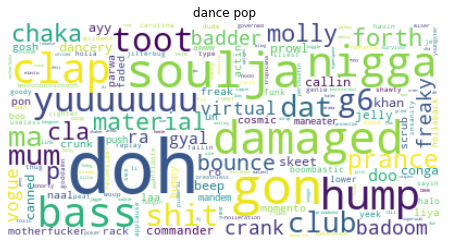

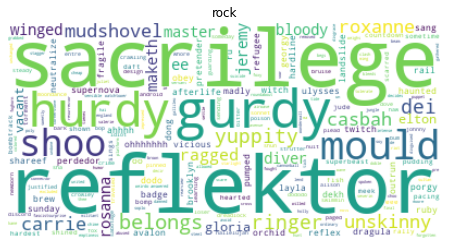

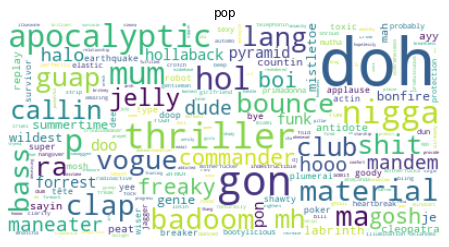

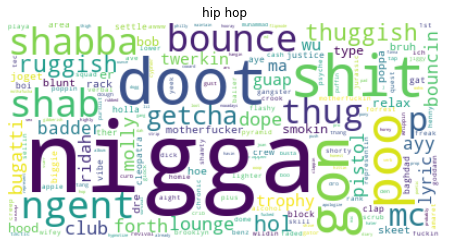

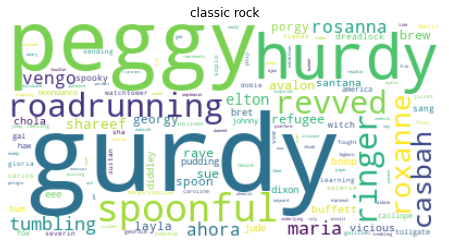

In [125]:
# Create a WordCloud for each comunity
for (key, tfidf_doc) in document_tfidf.items():
    doc_words = " ".join([(w + " ") * int(n) for w, n in Counter(tfidf_doc).most_common()])
    plot_word_cloud(doc_words, str(key))

# Lyrics sentiment score


## Sentiment by genres

We are interested to see what is the sentiment distribution for each genres.

In [ ]:
# compute sentiment based on genres
genres_sentiment = defaultdict(list)
for g, _ in genres_5:
    genres_sentiment[g] = np.mean(tracks_df[list(map(lambda genres:g in genres, tracks_df.genre))].sentiment)

In [126]:
print("Sentiment by genre\n")
for g, s in genres_sentiment.items():
    print(g,":",round(s,3))

Sentiment by genre

dance pop : 5.463
rock : 5.44
pop : 5.458
hip hop : 5.422
classic rock : 5.482


## Sentiment by artist

We are interested to see what is the sentiment value for the most 5 popular artists:

In [127]:
# extract top 5 most popular artists
artists_5 = Counter([artist for artists in spotify_df.artistname for artist in artists]).most_common(5)

# compute the sentiment score for top 5 artists
artists_sentiment = defaultdict(list)
for a, _ in artists_5:
    artists_sentiment[a] = np.mean(tracks_df[list(map(lambda art: a in art, tracks_df.artistname))].sentiment)

In [128]:
print("Sentiment by artist\n")
for a, s in artists_sentiment.items():
    print(a,":",round(s,3))

Sentiment by artist

daft punk : 5.528
coldplay : 5.464
radiohead : 5.377
the rolling stones : 5.339
eminem : 5.323


We're interested in seeing which artists are the happiest and the saddest.

In [129]:
# compute the sentiment score for all artists
artists_sentiment = []
for a in set([a for artists in tracks_df.artistname for a in artists]):
    artists_sentiment.append((a, np.mean(tracks_df[list(map(lambda art: a in art, tracks_df.artistname))].sentiment)))


In [157]:
artists_sentiment =  sorted(artists_sentiment, key=lambda t: t[1], reverse=True)

print("The most happiest 5 artist\n")
for a, s in artists_sentiment[:5]:
    print(a,":",round(s,3))

The most happiest 5 artist

gui boratto : 6.377
mase : 6.002
glenn miller : 5.999
k-ci : 5.988
art garfunkel : 5.961


In [134]:
list(tracks_df[list(map(lambda art: 'gui boratto' in art, tracks_df.artistname))].lyrics)

['What a beautiful life...\nWhat a beautiful world...\nWhat a beautiful life...\nWhat a beautiful world...\n\nWhat a beautiful life...\nWhat a beautiful life...\nWhat a beautiful world...\n\nI can see light...\nI can feel love...\nI can see the sun...\nWhat a beautiful life...\nWhat a beautiful life']

If we analyze the lyrics of the most happiest artist we can notice a high frequency of words as *beautiful*, *love*, *life*, *light* which have a high sentiment value.

In [156]:
artists_sentiment =  sorted(artists_sentiment, key=lambda t: t[1])

print("The most saddest 5 artist\n")
for a, s in artists_sentiment[:5]:
    print(a,":",round(s,3))

The most saddest 5 artist

flosstradamus : 4.9
herbie hancock : 4.976
serj tankian : 5.042
moby : 5.045
dj snake : 5.063


In [154]:
list(tracks_df[list(map(lambda art: 'flosstradamus' in art, tracks_df.artistname))].lyrics)

['Rollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\n\n*COUGH* *COUGH*\n\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\n\n*COUGH* *COUGH*\n\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\nRollup the grass, rollup rollup the grass\n\n*COUGH* *COUGH*']

Since Flosstradamus is a repressentat of the **trap genre** is lyrics does not necessarly convey a feeling. In this case, the most frequent word is *rollup*, which has 34 occurances, is not relevant for sentiment analysis. In this circumstances, the results of the sentiment analysis do not lead to any conclusion.

## Sentiment by artists' communities

## Sentiment by users' communities

In [160]:
comm_split = pd.read_pickle(r'/content/drive/MyDrive/SocialGraphs/Spotify_data/user_comm_split.pickle')

In [176]:
comm_sent = defaultdict(list)
for key, users in comm_split.items():
    user_tracks = list(spotify_df[spotify_df.user_id.isin(users)].trackname)
    comm_sent[key] = np.mean(tracks_df[list(map(lambda t: t in user_tracks, tracks_df.trackname))].sentiment)

In [177]:
print("Sentiment by users communities\n")
for c, s in comm_sent.items():
    print("Community", c,":",round(s,3))

Sentiment by users communities

Community 0 : 5.464
Community 1 : 5.463
Community 2 : 5.464
Community 3 : 5.464
Community 4 : 5.464
Community 5 : 5.461
Community 6 : 5.409
Community 7 : nan
Community 8 : 5.482
Community 9 : 5.42
Community 10 : 5.466
Community 11 : 5.469


(community 7 has only 2 tracks which are not in the track_df)